In [62]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie

OUTPUT_IMAGE_DIR = "./images"

In [63]:
# Download PUF zip
# URLs obtained by following transparency in coverage PUF links at: https://www.cms.gov/cciio/resources/data-resources/marketplace-puf
year = 2023
url = (
    f"https://download.cms.gov/marketplace-puf/{year}/transparency-in-coverage-puf.zip"
)
puf_zip_path = f"transparency_in_coverage_puf_{year}.zip"
download_file_from_url(url, puf_zip_path)

# Unzip
zipdata = zipfile.ZipFile(puf_zip_path)
zipinfo = zipdata.infolist()[0]  # Single file in each zip

# Rename file to enforce consistency across years and handle with same boilerplate
zipinfo.filename = f"transparency_in_coverage_puf_{year}.xlsx"
puf_path = zipdata.extract(zipinfo)

# Delete zip
os.remove(puf_zip_path)

Success.


### Helper Functions


In [64]:
def read_and_split_puf_sheet(puf_path, sheet_name):
    """Split off the title, legend and actual data from CMS puf sheet."""
    df = pd.read_excel(puf_path, engine="openpyxl", sheet_name=sheet_name)
    title = df.keys()[0]
    legend = df.iloc[0][0]

    # reassign header
    data = df.iloc[1:]
    headers = data.iloc[0]
    data = data[1:]
    data.columns = headers

    return title, legend, data


def get_issuer_level_dfs(dfs):
    """Isolate a dataframe containing all issuer level data for each df in dfs."""
    issuer_level_dfs = []
    for df in dfs:
        issuer_const_cols = [
            "Issuer_ID",
            "State",
            "Issuer_Name",
            "Is_Issuer_New_to_Exchange? (Yes_or_No)",
            "SADP_Only?",
            "QHP/SADP",
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
        ]
        issuer_level_df = df.groupby(issuer_const_cols, as_index=False).first()
        issuer_level_df = issuer_level_df[issuer_const_cols]
        issuer_level_dfs.append(issuer_level_df)
    return issuer_level_dfs


def get_denial_rate(
    row, recvd_col="Issuer_Claims_Received", denied_col="Issuer_Claims_Denials"
):
    recvd = row[recvd_col]
    denied = row[denied_col]
    if recvd == 0:
        return -1
    if type(recvd) is str and type(denied) is str:
        return int(denied) / int(recvd)
    if type(recvd) is int and type(denied) is int:
        return denied / recvd
    else:
        return -1

### Read Data


In [65]:
# The Qualified Health Plan (QHP) data is delivered as a sheet in an xlsx file, but with a title row and legend row,
# which makes parsing this as a dataframe unnecessarily involved. Why CMS, just why? A humble request: can document the legend and title
# in a separate file or readme moving forward, so that the data can be read without having to study the header formats that vary year to year?
sheet_name = f"Transparency {year} - Ind QHP"
title, legend, df = read_and_split_puf_sheet(puf_path, sheet_name)

In [66]:
# Legend
print(f"{title}\n\n{legend}")

Individual Marketplace Medical Qualified Health Plans (QHPs)

Legend 
*                              Data not available for this issuer/plan
**                            Suppressed data due to small cell sizes                  
***                          Data not required due to plan type
N/A                         Data not applicable because issuer or plan offering is new to the Exchange
Missing URL            Financial Link unavailable on NAIC website


### Clean and Group Data


In [67]:
def filter_rows_missing_data(
    df,
    cols=[
        "Issuer_Claims_Received",
        "Issuer_Claims_Denials",
        "Issuer_Internal_Appeals_Filed",
        "Issuer_Number_Internal_Appeals_Overturned",
        "Issuer_External_Appeals_Filed",
        "Issuer_Number_External_Appeals_Overturned",
    ],
    disallowed_values=["*", "**"],
):
    """Filter out rows for which any of the input columns contain null, * or ** values."""

    # Filter out null and disallowed strs
    filtered_df = df.copy(deep=True)
    for col in cols:
        pre_len = len(filtered_df)
        filtered_df = filtered_df[
            ~(filtered_df[col].isnull() | filtered_df[col].isin(disallowed_values))
        ]
        removed_rows = pre_len - len(filtered_df)
        if removed_rows > 0:
            print(
                f"Removed {removed_rows} rows for which column '{col}' is null or in {disallowed_values}"
            )

    return filtered_df


def cast_to_int(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Cast list of specified columns in df to int.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe on which to cast types.
    cols : list[str]
        Columns in dataframe.

    Returns
    -------
    pd.DataFrame
        Dataframe with updated types.
    """
    conversion_dict = {name: int for name in cols}
    df = df.astype(conversion_dict)
    return df


def retain_a_geq_b(df, a, b):
    """Retain only rows for which col a is greater than or equal to col b."""
    pre_len = len(df)
    filtered_df = df[df[a] >= df[b]]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting {b} > {a}")

    return filtered_df


def filter_erroneous_plan_claims(df):
    """Filter plan for which claims received are less than claims denied."""
    pre_len = len(df)
    filtered_df = df[df["Issuer_Claims_Received"] > df["Issuer_Claims_Denials"]]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting more denials than claims.")

    return filtered_df


def isolate_medical(df):
    df = df[df["SADP_Only?"] == "No"]
    return df


def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df

In [68]:
# Isolate QHP medical plans
df = isolate_medical(df)
df = isolate_QHP(df)

In [69]:
# Isolate issuers with denial rate data.
base_cols = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]
issuer_base = filter_rows_missing_data(
    df, cols=base_cols, disallowed_values=["*", "**"]
)
issuer_base = cast_to_int(issuer_base, base_cols)
issuer_base = get_issuer_level_dfs([issuer_base])[0]
issuer_base = retain_a_geq_b(
    issuer_base, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']


In [70]:
# Isolate issuers with denial rate + internal appeal result data
internal_cols = base_cols + [
    "Issuer_Internal_Appeals_Filed",
    "Issuer_Number_Internal_Appeals_Overturned",
]
issuer_internal = filter_rows_missing_data(
    df, cols=internal_cols, disallowed_values=["*", "**"]
)
issuer_internal = cast_to_int(issuer_internal, internal_cols)
issuer_internal = get_issuer_level_dfs([issuer_internal])[0]
issuer_internal = retain_a_geq_b(
    issuer_internal, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)
issuer_internal = retain_a_geq_b(
    issuer_internal,
    a="Issuer_Internal_Appeals_Filed",
    b="Issuer_Number_Internal_Appeals_Overturned",
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']
Removed 324 rows for which column 'Issuer_Internal_Appeals_Filed' is null or in ['*', '**']
Removed 292 rows for which column 'Issuer_Number_Internal_Appeals_Overturned' is null or in ['*', '**']
Removed 1 rows reporting Issuer_Number_Internal_Appeals_Overturned > Issuer_Internal_Appeals_Filed


In [71]:
# Isolate issuers with denial rate + internal appeal result data + external appeal data
external_cols = internal_cols + [
    "Issuer_External_Appeals_Filed",
    "Issuer_Number_External_Appeals_Overturned",
]
issuer_external = filter_rows_missing_data(
    df, cols=external_cols, disallowed_values=["*", "**"]
)
issuer_external = cast_to_int(issuer_external, external_cols)
issuer_external = get_issuer_level_dfs([issuer_external])[0]
issuer_external = retain_a_geq_b(
    issuer_external, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)
issuer_external = retain_a_geq_b(
    issuer_external,
    a="Issuer_Internal_Appeals_Filed",
    b="Issuer_Number_Internal_Appeals_Overturned",
)
issuer_external = retain_a_geq_b(
    issuer_external,
    a="Issuer_External_Appeals_Filed",
    b="Issuer_Number_External_Appeals_Overturned",
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']
Removed 324 rows for which column 'Issuer_Internal_Appeals_Filed' is null or in ['*', '**']
Removed 292 rows for which column 'Issuer_Number_Internal_Appeals_Overturned' is null or in ['*', '**']
Removed 1684 rows for which column 'Issuer_External_Appeals_Filed' is null or in ['*', '**']
Removed 630 rows for which column 'Issuer_Number_External_Appeals_Overturned' is null or in ['*', '**']
Removed 1 rows reporting Issuer_Number_Internal_Appeals_Overturned > Issuer_Internal_Appeals_Filed


In [72]:
# Isolate plan data with denial rate info
base_cols = ["Plan_Number_Claims_Received", "Plan_Number_Claims_Denied"]
plan_base = filter_rows_missing_data(df, cols=base_cols)
plan_base = cast_to_int(plan_base, base_cols)
plan_base = retain_a_geq_b(
    plan_base, a="Plan_Number_Claims_Received", b="Plan_Number_Claims_Denied"
)

Removed 4608 rows for which column 'Plan_Number_Claims_Received' is null or in ['*', '**']
Removed 37 rows for which column 'Plan_Number_Claims_Denied' is null or in ['*', '**']


In [73]:
# Isolate plan data with denial rate + breakdown data
inn_rationale_cols = [
    "Plan_Number_Claims_Denied_Referral_Required",
    "Plan_Number_Claims_Denied_Services_Excluded",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only",
    "Plan_Number_Claims_Denied_Other",
]
rationale_cols = inn_rationale_cols + ["Plan_Number_Claims_Denied_Out_of_Network"]
breakdown_cols = base_cols + rationale_cols
plan_breakdown = filter_rows_missing_data(df, cols=breakdown_cols)
plan_breakdown = cast_to_int(plan_breakdown, breakdown_cols)
plan_breakdown = retain_a_geq_b(
    plan_breakdown, a="Plan_Number_Claims_Received", b="Plan_Number_Claims_Denied"
)


# Enforce breakdowns consistently sum to total count
# Seems like different plans opt to include OON denials as part of total denials, others do not
plan_breakdown_oon_incl = plan_breakdown[
    plan_breakdown["Plan_Number_Claims_Denied"]
    == plan_breakdown[rationale_cols].sum(axis=1)
]
plan_breakdown_oon_excl = plan_breakdown[
    plan_breakdown["Plan_Number_Claims_Denied"]
    == plan_breakdown[inn_rationale_cols].sum(axis=1)
]

Removed 4608 rows for which column 'Plan_Number_Claims_Received' is null or in ['*', '**']
Removed 37 rows for which column 'Plan_Number_Claims_Denied' is null or in ['*', '**']
Removed 202 rows for which column 'Plan_Number_Claims_Denied_Referral_Required' is null or in ['*', '**']
Removed 118 rows for which column 'Plan_Number_Claims_Denied_Services_Excluded' is null or in ['*', '**']
Removed 400 rows for which column 'Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health' is null or in ['*', '**']
Removed 226 rows for which column 'Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only' is null or in ['*', '**']
Removed 1 rows for which column 'Plan_Number_Claims_Denied_Other' is null or in ['*', '**']
Removed 121 rows for which column 'Plan_Number_Claims_Denied_Out_of_Network' is null or in ['*', '**']


### High Level Stats


In [74]:
# Issuer data
print(f"{len(df['Issuer_ID'].unique())} issuers in data.")
print(f"{len(issuer_base)} issuers reporting data sufficient to calculate denial rate.")
print(
    f"{len(issuer_internal)} issuers reporting data sufficient to calculate internal appeal success rates."
)
print(
    f"{len(issuer_external)} issuers reporting data sufficient to calculate external appeal success rates."
)

230 issuers in data.
163 issuers reporting data sufficient to calculate denial rate.
133 issuers reporting data sufficient to calculate internal appeal success rates.
56 issuers reporting data sufficient to calculate external appeal success rates.


In [75]:
# Plan data
print(f"{len(df['Plan_ID'].unique())} plans in data.")
print(f"{len(plan_base)} plans reporting data sufficient to calculate denial rate.")
print(
    f"{len(plan_breakdown_oon_incl)} plans reporting denial rationales that sum to denied claims."
)
print(
    f"{len(plan_breakdown_oon_excl)} plans reporting denial rationales that sum to denied claims when not including OON denials."
)

6764 plans in data.
2119 plans reporting data sufficient to calculate denial rate.
382 plans reporting denial rationales that sum to denied claims.
348 plans reporting denial rationales that sum to denied claims when not including OON denials.


#### Base Denial Rates

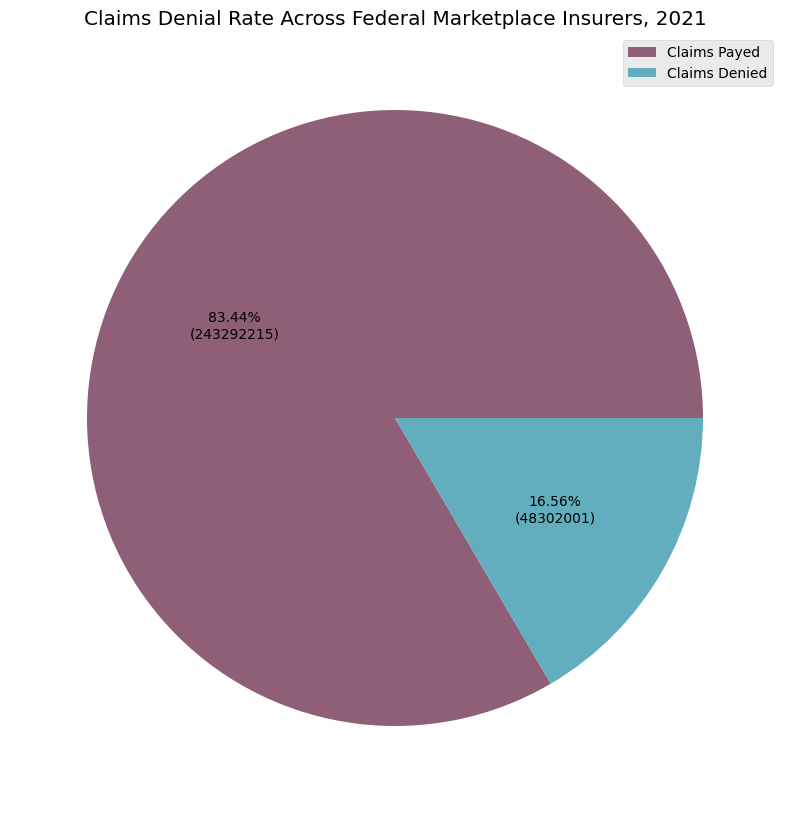

In [76]:
total_claims_received = (
    issuer_base[~issuer_base["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
total_claims_denied = (
    issuer_base[~issuer_base["Issuer_Claims_Denials"].isnull()]["Issuer_Claims_Denials"]
    .astype(int)
    .sum()
)

# Reproduce KFF Pie Chart
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_claims_received - total_claims_denied, total_claims_denied],
    title="Claims Denial Rate Across Federal Marketplace Insurers, 2021",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie.png"),
)

Question: Can we find average price of a claim to make some back of envelope calculations here about the total monetary cost being passed on to consumers (or, if denied claims result in lack of care received, value of forgone care)?

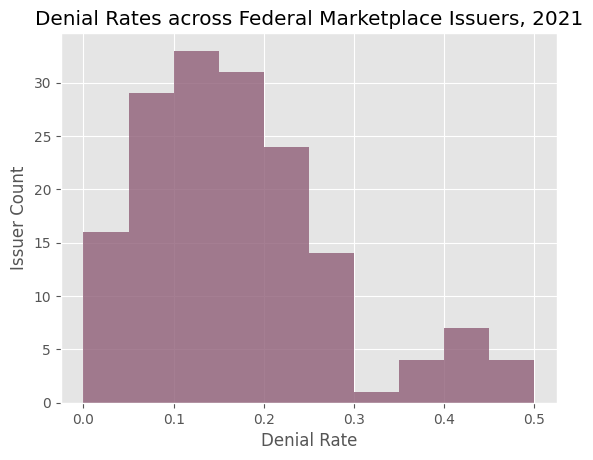

In [77]:
# Calculate issuer level denial rates
issuer_base["denial_rate"] = issuer_base.apply(get_denial_rate, axis=1)
issuer_denial_rates = issuer_base[issuer_base["denial_rate"] != -1]

# Hist
plot_hist(
    issuer_denial_rates["denial_rate"],
    bins=np.linspace(0, 0.5, 11),
    title="Denial Rates across Federal Marketplace Issuers, 2021",
    y_label="Issuer Count",
    x_label="Denial Rate",
)

# Average = ?

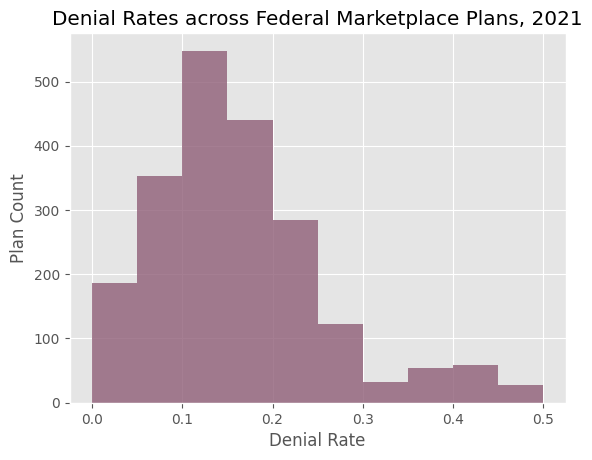

In [78]:
# Calculate plan level denial rates
plan_base["denial_rate"] = plan_base.apply(
    partial(
        get_denial_rate,
        recvd_col="Plan_Number_Claims_Received",
        denied_col="Plan_Number_Claims_Denied",
    ),
    axis=1,
)
plan_denial_rates = plan_base[plan_base["denial_rate"] != -1]

# Hist
plot_hist(
    plan_denial_rates["denial_rate"],
    bins=np.linspace(0, 0.5, 11),
    title="Denial Rates across Federal Marketplace Plans, 2021",
    y_label="Plan Count",
    x_label="Denial Rate",
)

# Average = ?

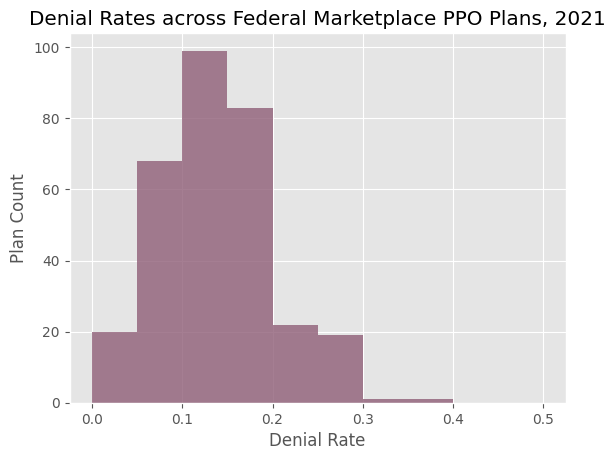

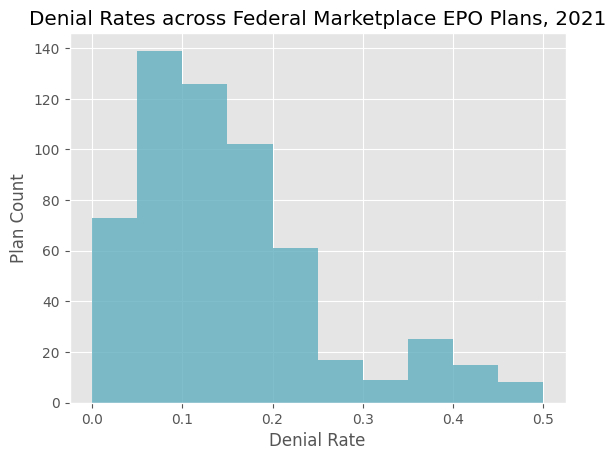

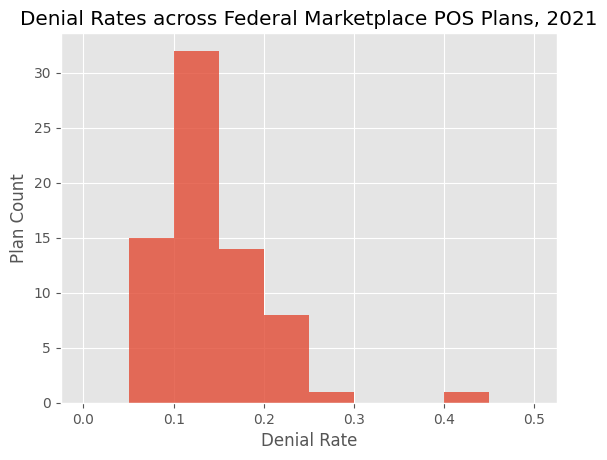

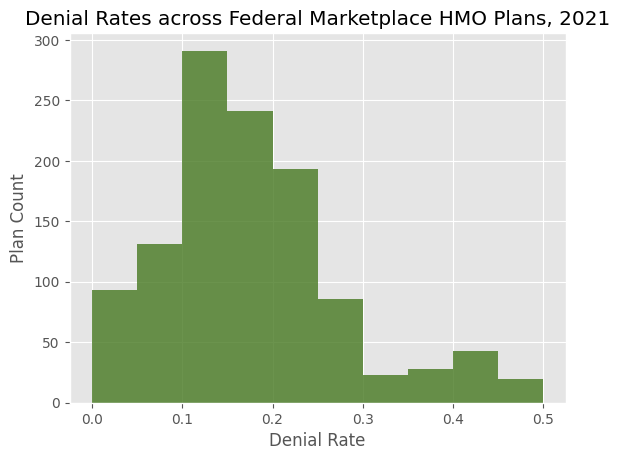

In [79]:
# Break down by plan type
plan_types = plan_base["Plan_Type"].unique()
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, ptype in enumerate(plan_types):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["Plan_Type"] == ptype]["denial_rate"]
    ax.hist(type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 11), color=cycle[idx])
    ax.set_title(f"Denial Rates across Federal Marketplace {ptype} Plans, 2021")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

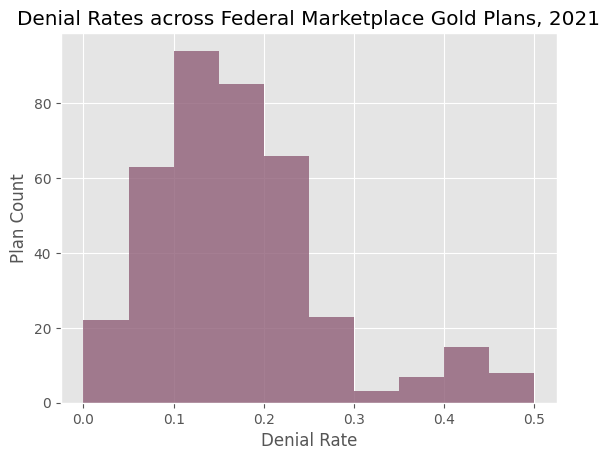

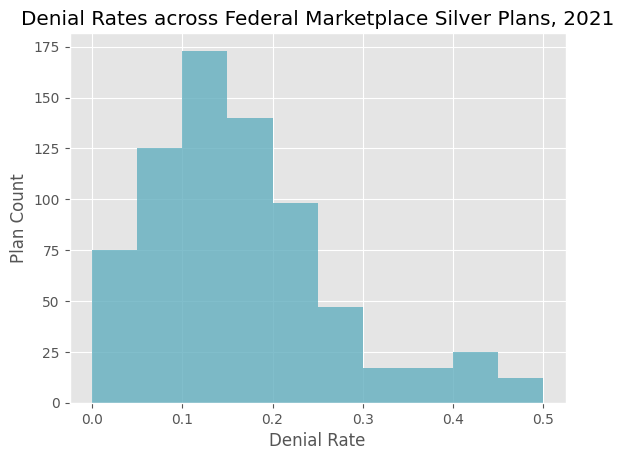

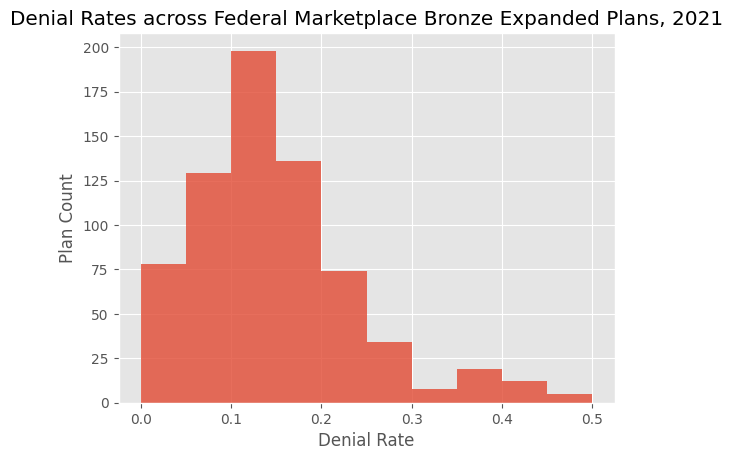

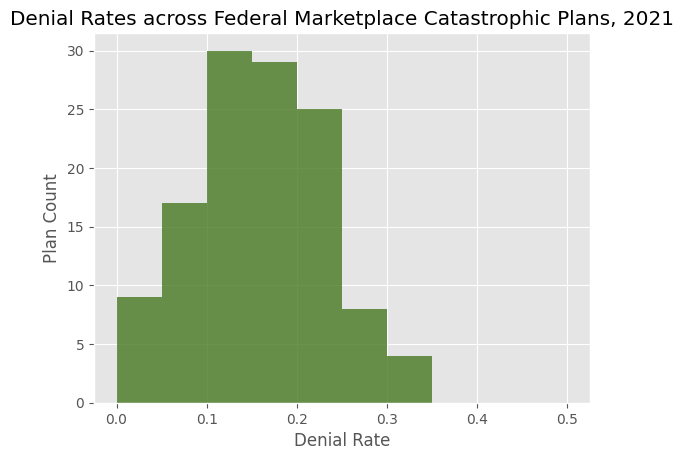

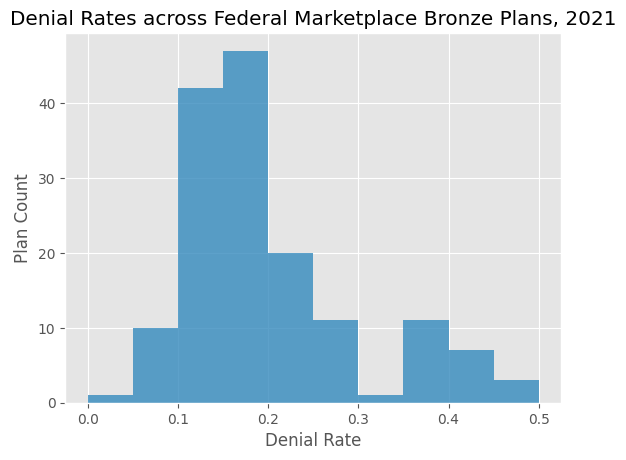

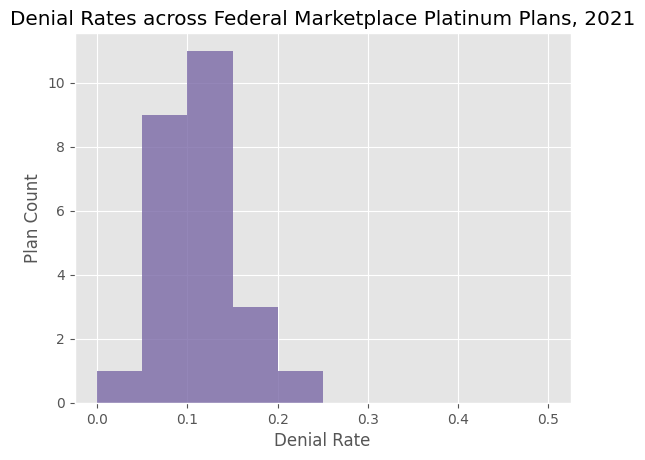

In [80]:
# Break down by metal level
plan_metals = plan_base["Metal_Level"].unique()
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, mtype in enumerate(plan_metals):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["Metal_Level"] == mtype]["denial_rate"]
    ax.hist(type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 11), color=cycle[idx])
    ax.set_title(f"Denial Rates across Federal Marketplace {mtype} Plans, 2021")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

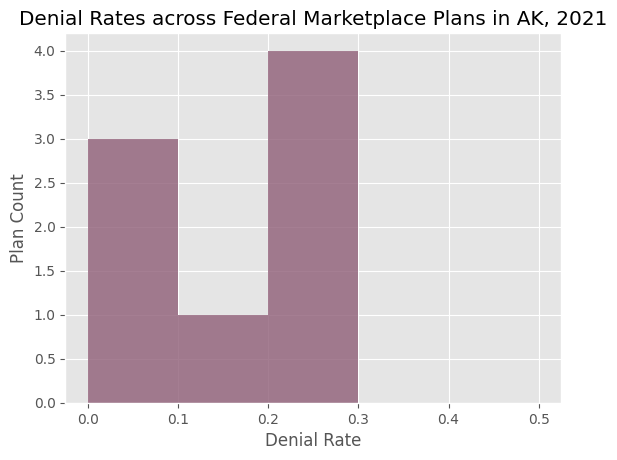

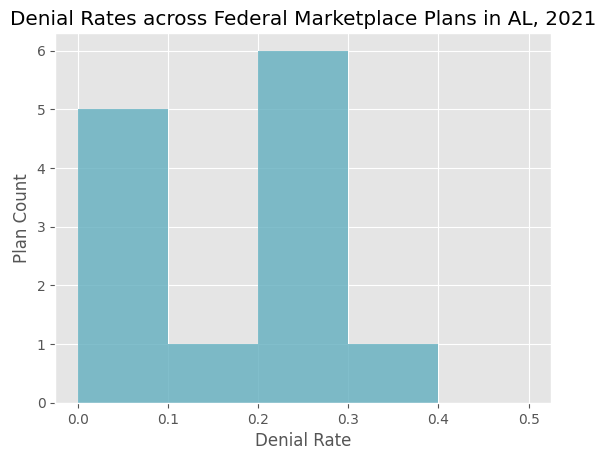

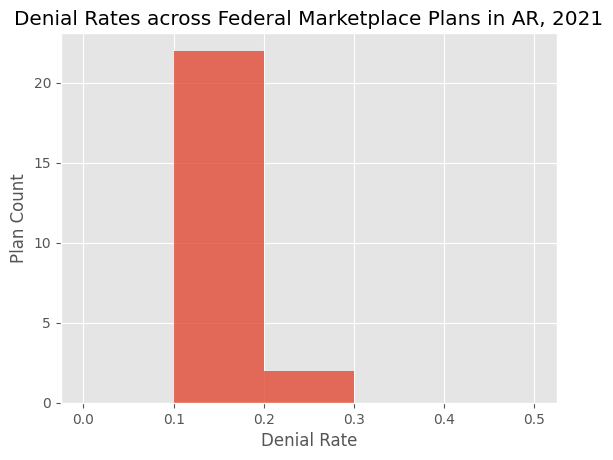

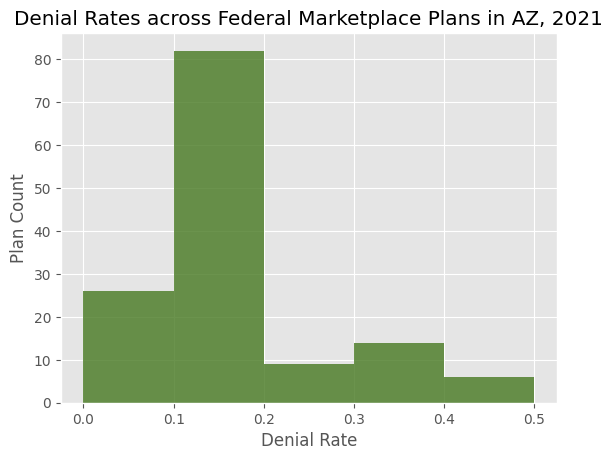

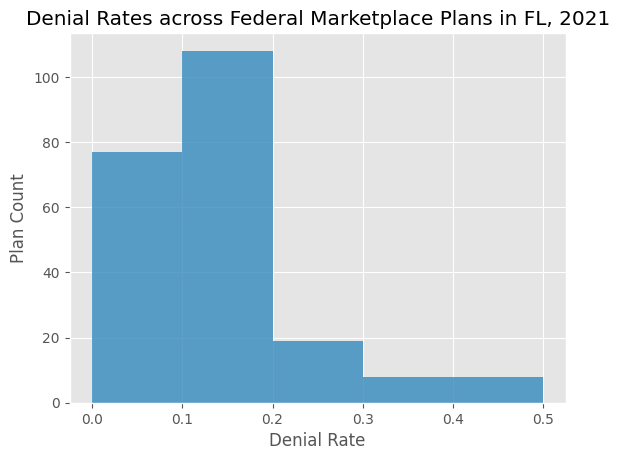

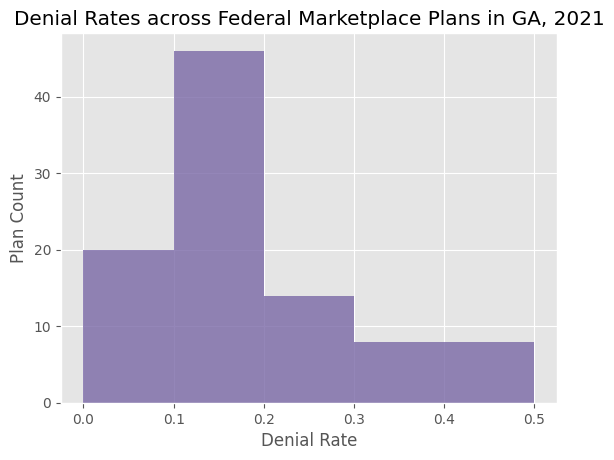

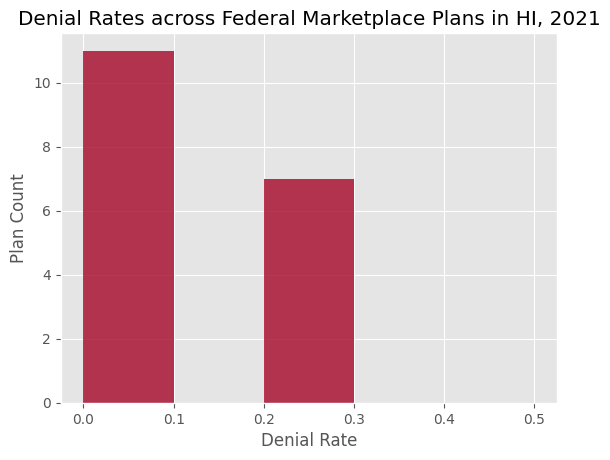

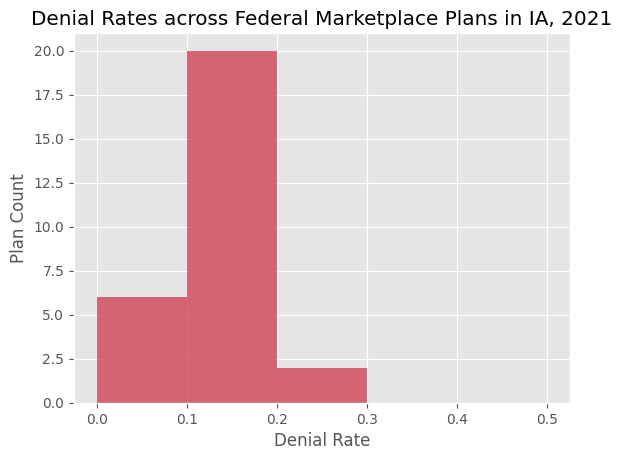

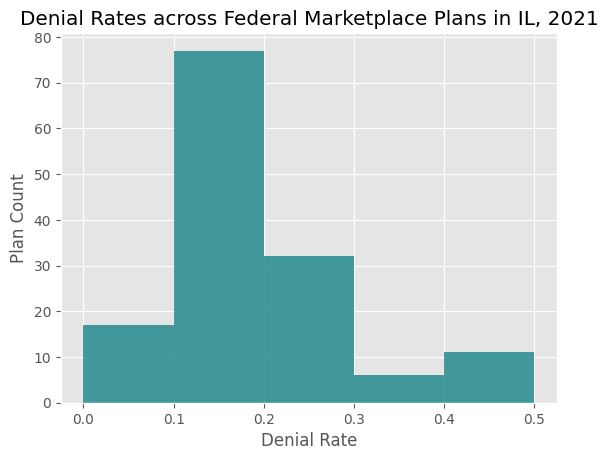

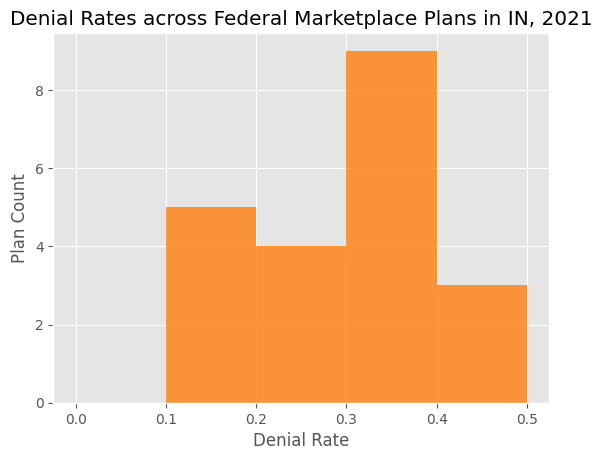

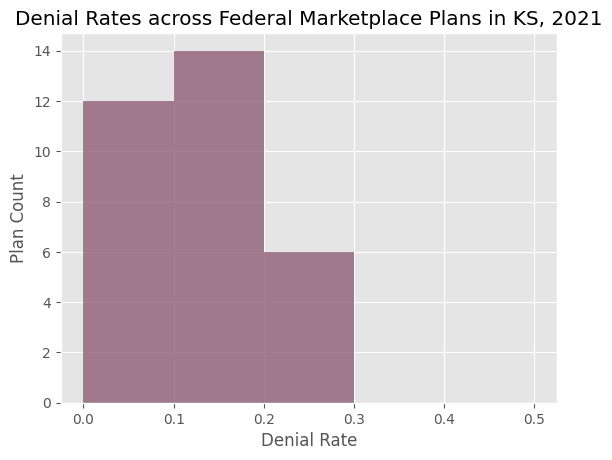

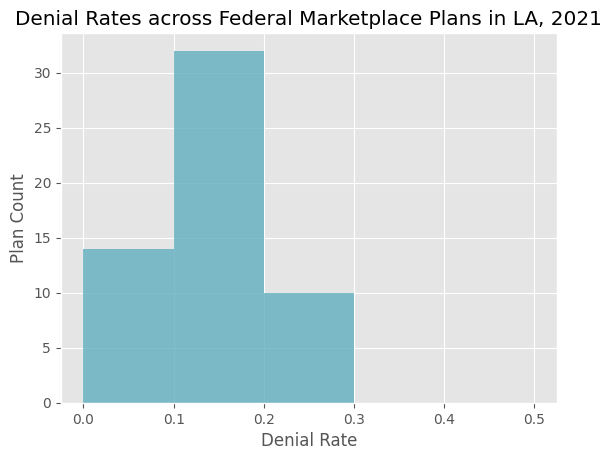

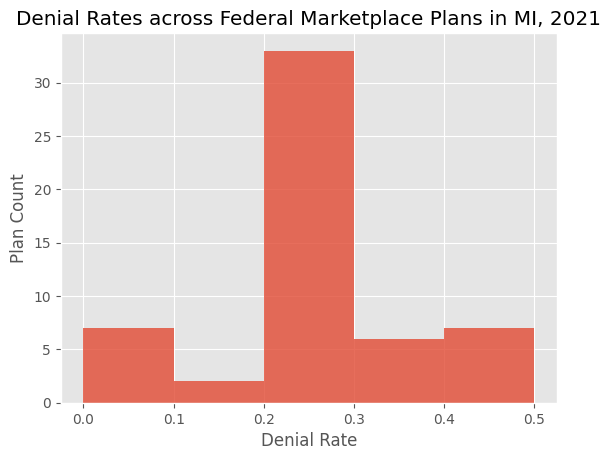

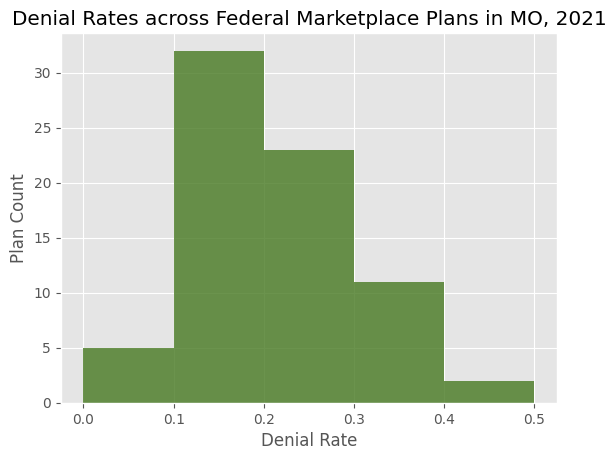

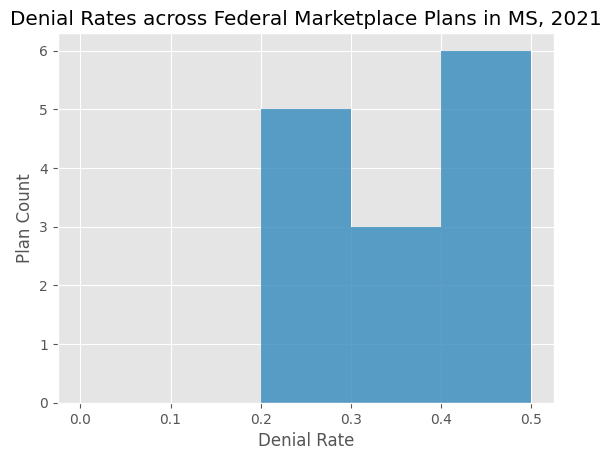

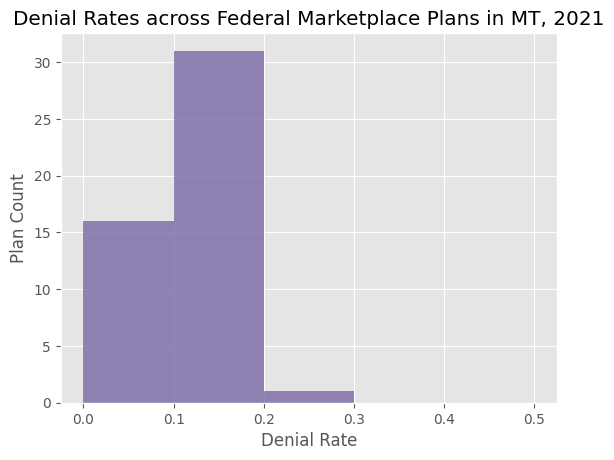

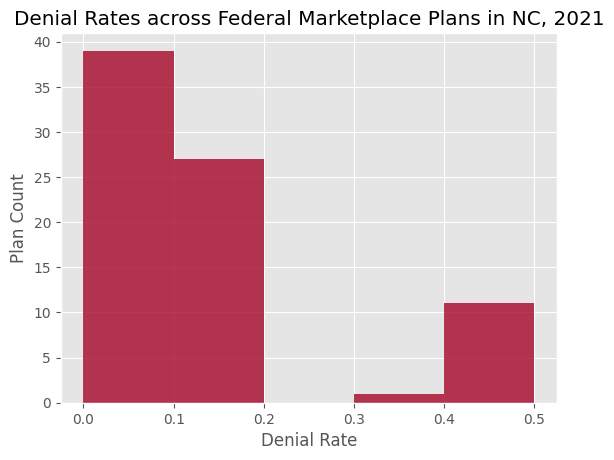

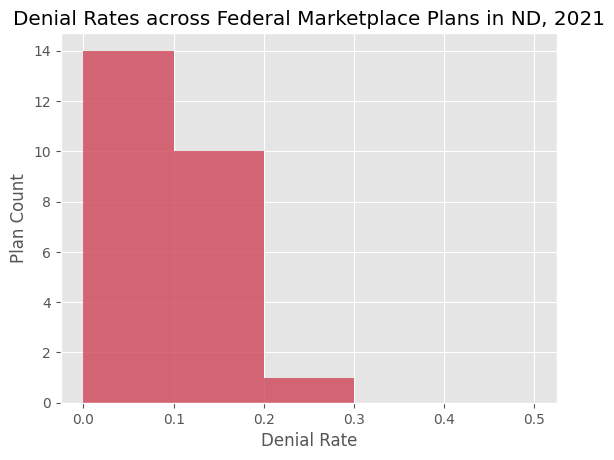

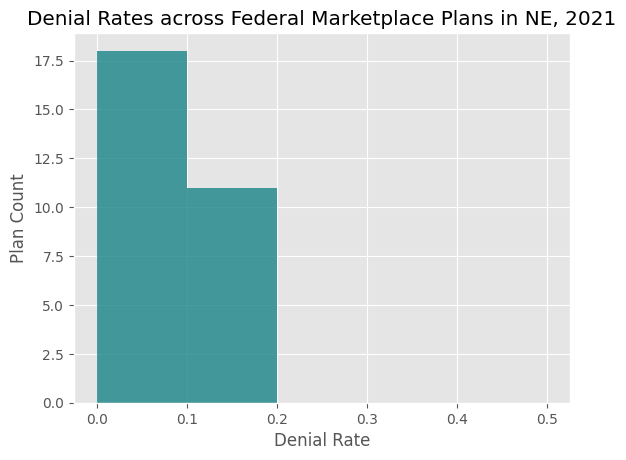

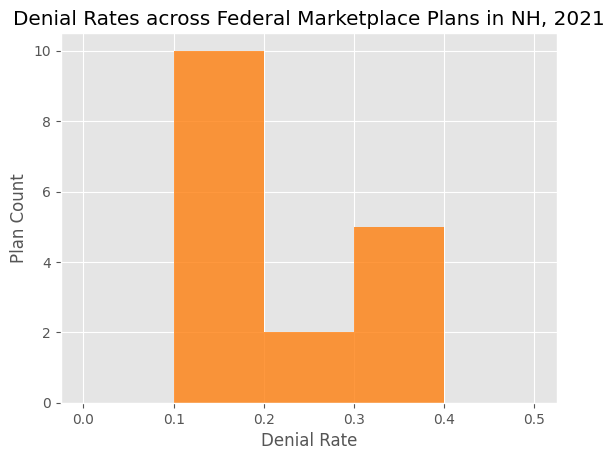

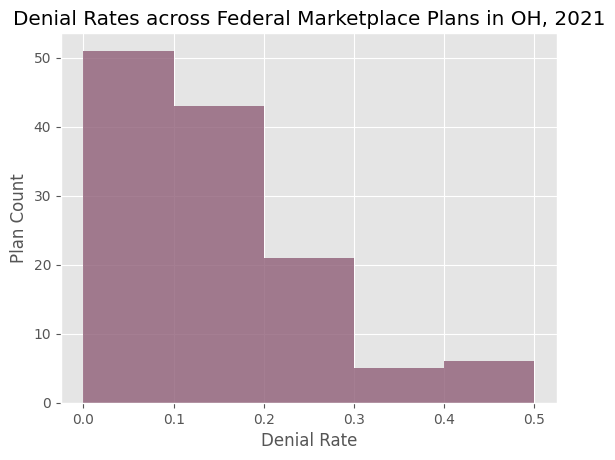

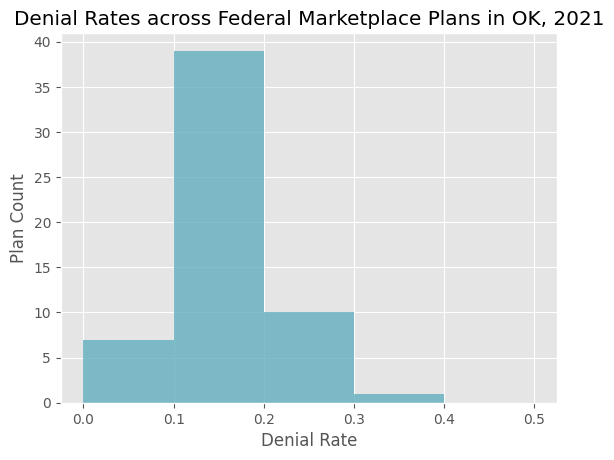

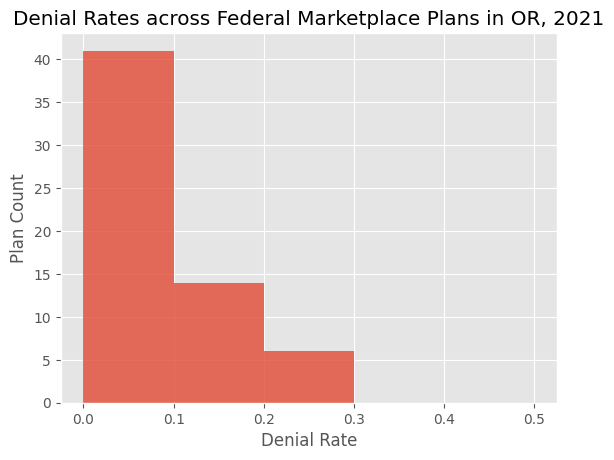

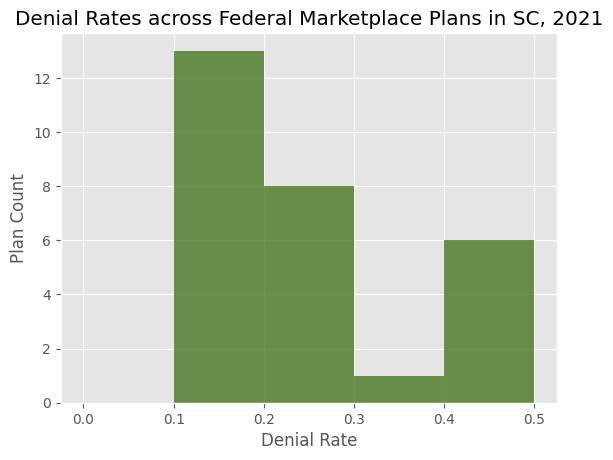

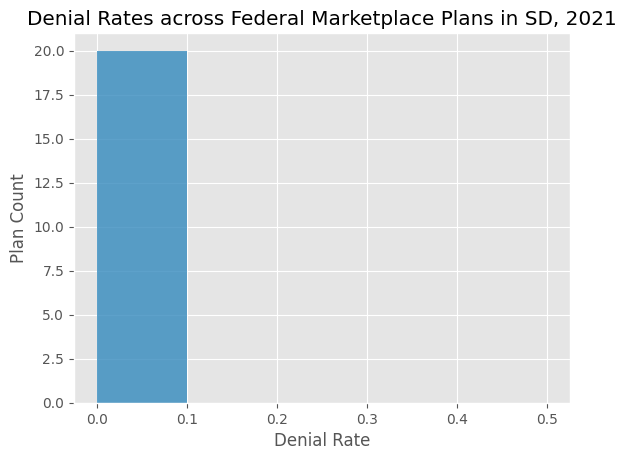

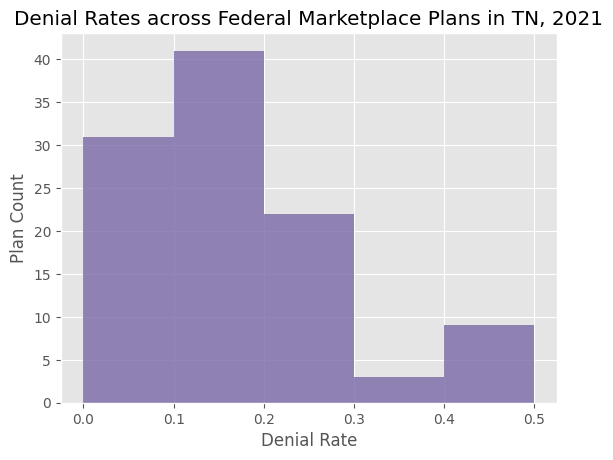

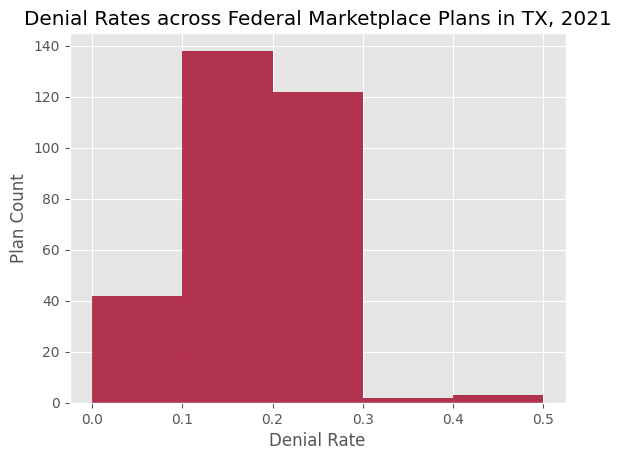

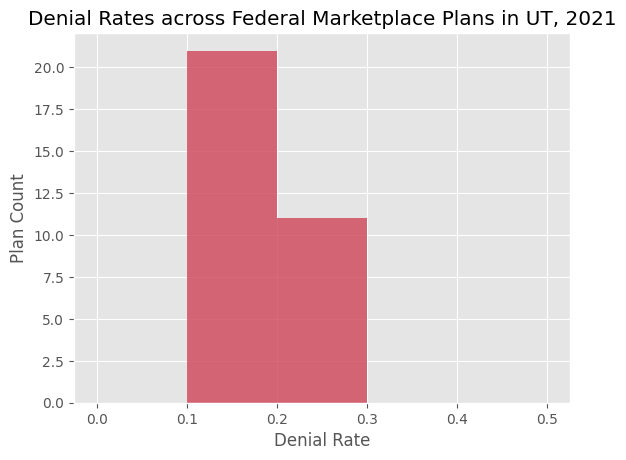

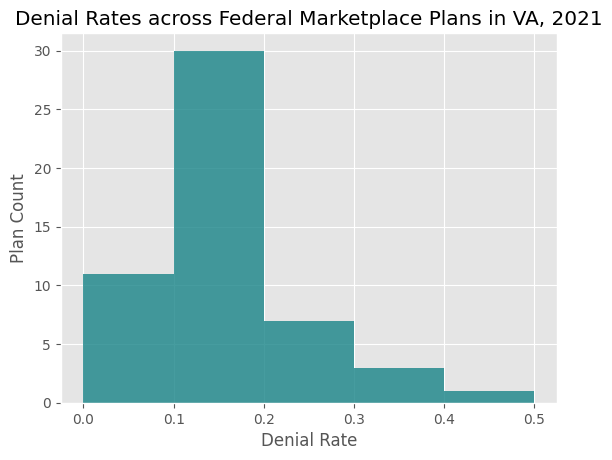

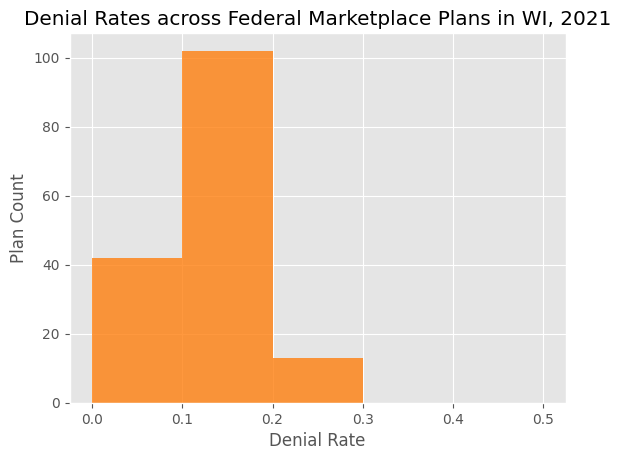

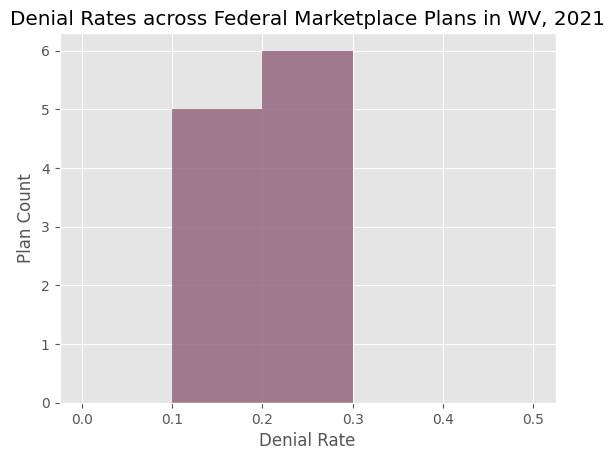

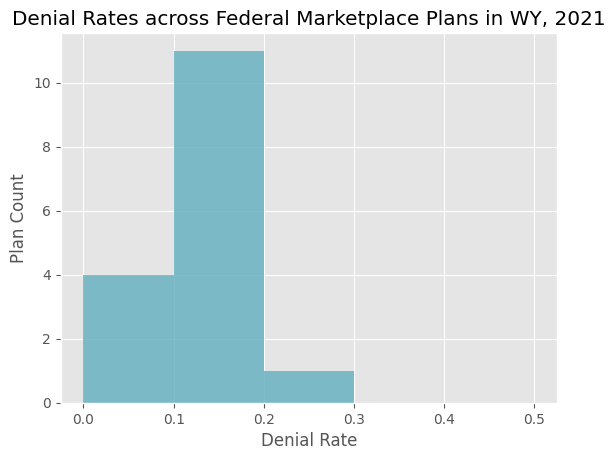

In [81]:
# Break down by state
plan_states = sorted(plan_base["State"].unique())
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, state in enumerate(plan_states):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["State"] == state]["denial_rate"]
    ax.hist(
        type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 6), color=cycle[idx % len(cycle)]
    )
    ax.set_title(f"Denial Rates across Federal Marketplace Plans in {state}, 2021")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

# TODO: Make javascript widget to select state, get hist breakdown in addition to average denial rate for state.

In [82]:
# Create dict of state denial rates for export
state_denial_data = {}
issuer_states = sorted(issuer_base["State"].unique())
for idx, state in enumerate(plan_states):
    state_issuers = issuer_base[issuer_base["State"] == state]
    state_issuers_sorted = state_issuers.sort_values(
        by="Issuer_Claims_Denials", ascending=False
    )
    total_received = int(state_issuers_sorted["Issuer_Claims_Received"].sum())
    total_denied = int(state_issuers_sorted["Issuer_Claims_Denials"].sum())
    denial_rate = round(total_denied / total_received, 3)
    state_issuers = state_issuers_sorted["Issuer_Name"].values
    top_issuers = list(state_issuers[:3])
    num_issuers = len(state_issuers)
    # Total issuers represented
    state_denial_data[state] = {
        "claims_received": total_received,
        "claims_denied": total_denied,
        "denial_rate": denial_rate,
        "top_issuers": top_issuers,
        "num_issuers_represented": num_issuers,
    }
with open("state_denial_data.json", "w") as outfile:
    json.dump(state_denial_data, outfile)

#### Appeal Rates

##### Among Issuers Reporting Internal Appeals Data

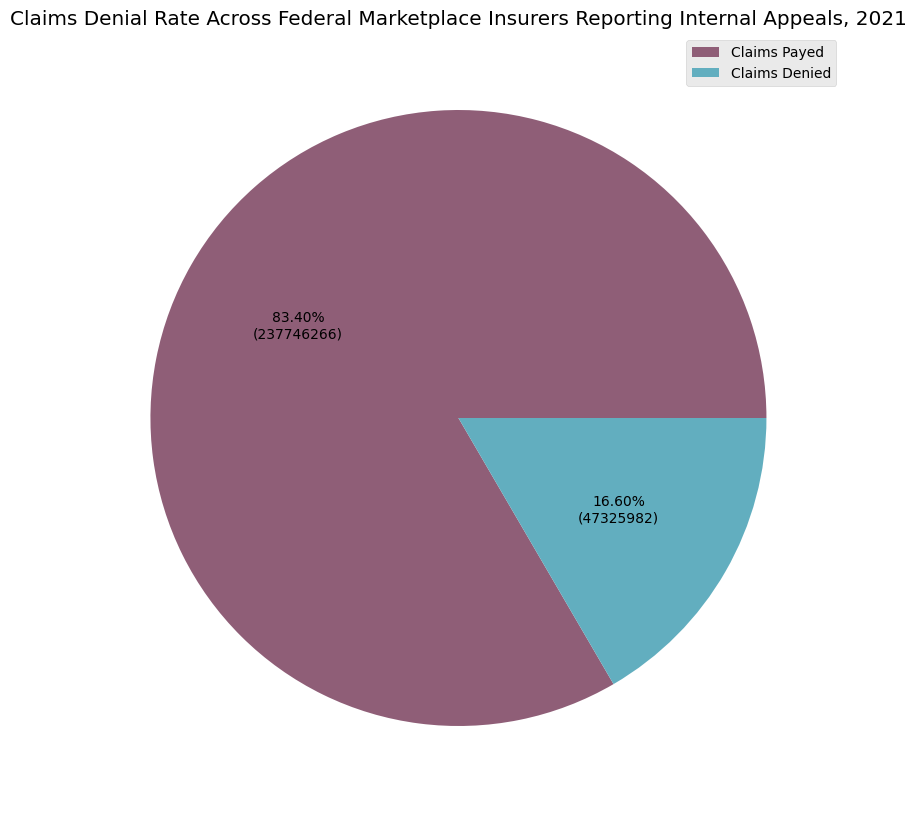

In [83]:
#### Denial Rate Among those reporting Internal Appeals
claims_received = (
    issuer_internal[~issuer_internal["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
claims_denied = (
    issuer_internal[~issuer_internal["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[claims_received - claims_denied, claims_denied],
    title="Claims Denial Rate Across Federal Marketplace Insurers Reporting Internal Appeals, 2021",
    show=True,
)

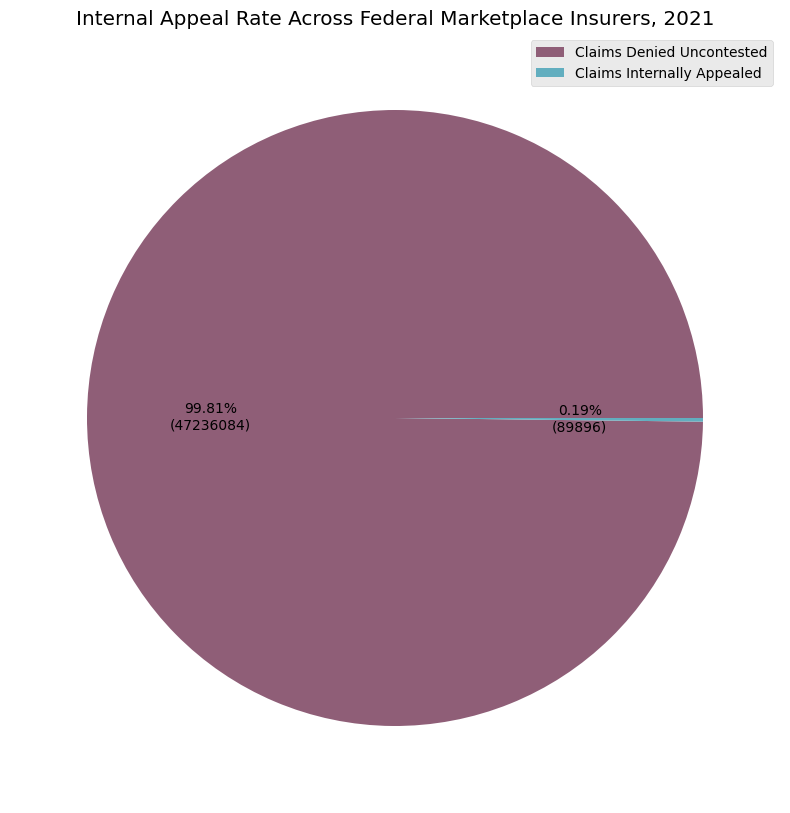

In [84]:
#### Internal Appeal Rate
claims_denied = (
    issuer_internal[~issuer_internal["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

# Issuer_Internal_Appeals_Filed

# Issuer_Number_Internal_Appeals_Overturned

claims_internally_appealed = (
    issuer_internal[~issuer_internal["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_internally_appealed, claims_internally_appealed],
    title="Internal Appeal Rate Across Federal Marketplace Insurers, 2021",
    show=True,
)

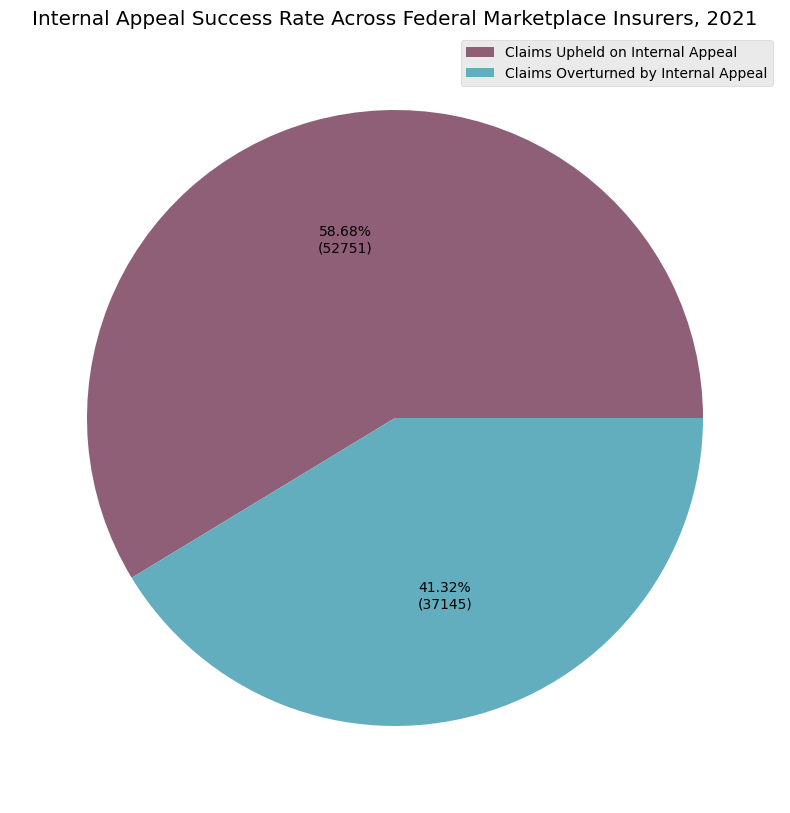

In [85]:
#### Internal Appeal Success Rate
claims_internally_overturned = (
    issuer_internal[
        ~issuer_internal["Issuer_Number_Internal_Appeals_Overturned"].isnull()
    ]["Issuer_Number_Internal_Appeals_Overturned"]
    .astype(int)
    .sum()
)

claims_internally_appealed = (
    issuer_internal[~issuer_internal["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[
        claims_internally_appealed - claims_internally_overturned,
        claims_internally_overturned,
    ],
    title="Internal Appeal Success Rate Across Federal Marketplace Insurers, 2021",
    show=True,
)

##### Among Issuers Reporting External Appeals Data

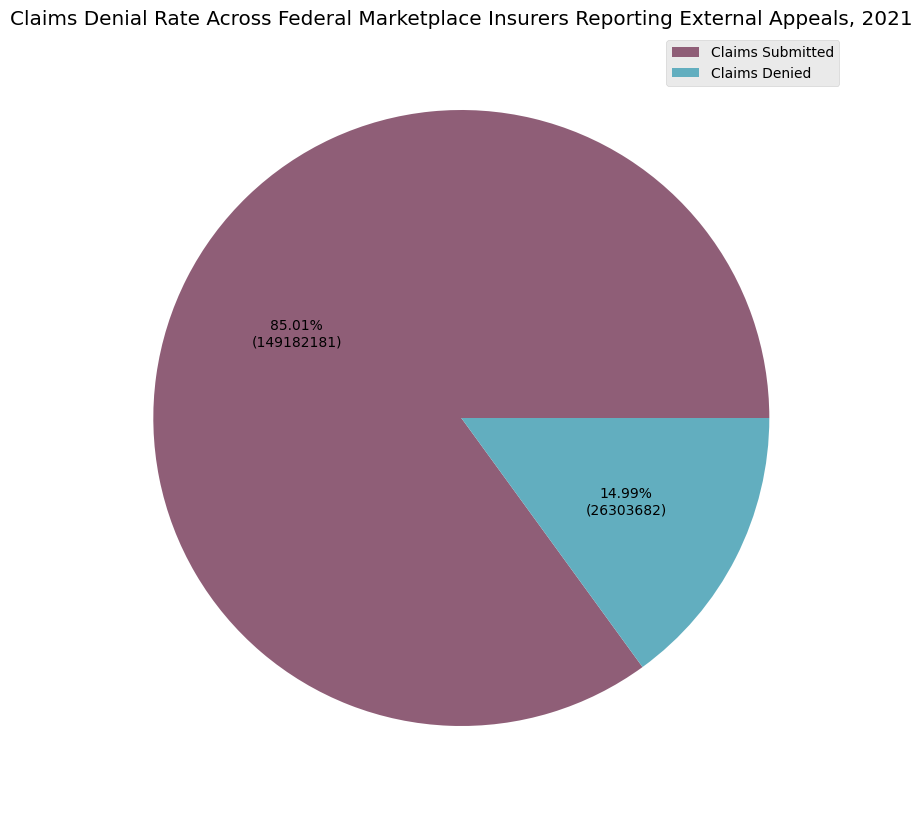

In [91]:
#### Denial Rate Among those reporting External
claims_received = (
    issuer_external[~issuer_external["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
claims_denied = (
    issuer_external[~issuer_external["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Submitted", "Claims Denied"],
    slice_vals=[claims_received - claims_denied, claims_denied],
    title="Claims Denial Rate Across Federal Marketplace Insurers Reporting External Appeals, 2021",
    show=True,
)

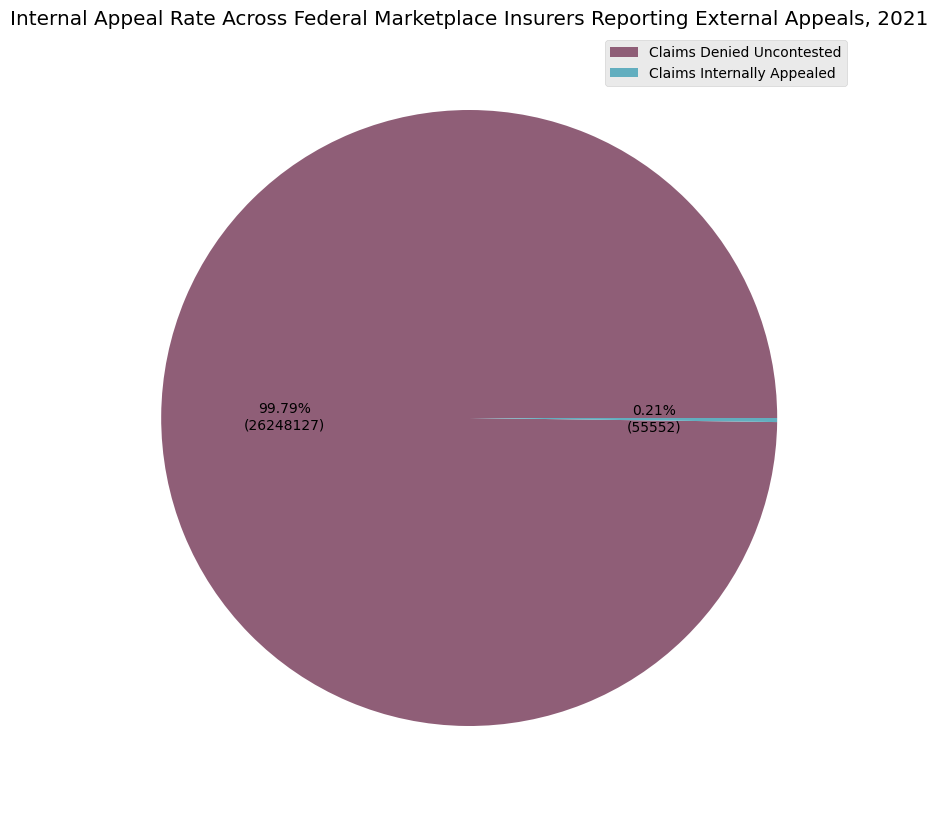

In [92]:
#### Internal Appeal Rate
claims_denied = (
    issuer_external[~issuer_external["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

# Issuer_Internal_Appeals_Filed

# Issuer_Number_Internal_Appeals_Overturned

claims_internally_appealed = (
    issuer_external[~issuer_external["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_internally_appealed, claims_internally_appealed],
    title="Internal Appeal Rate Across Federal Marketplace Insurers Reporting External Appeals, 2021",
    show=True,
)

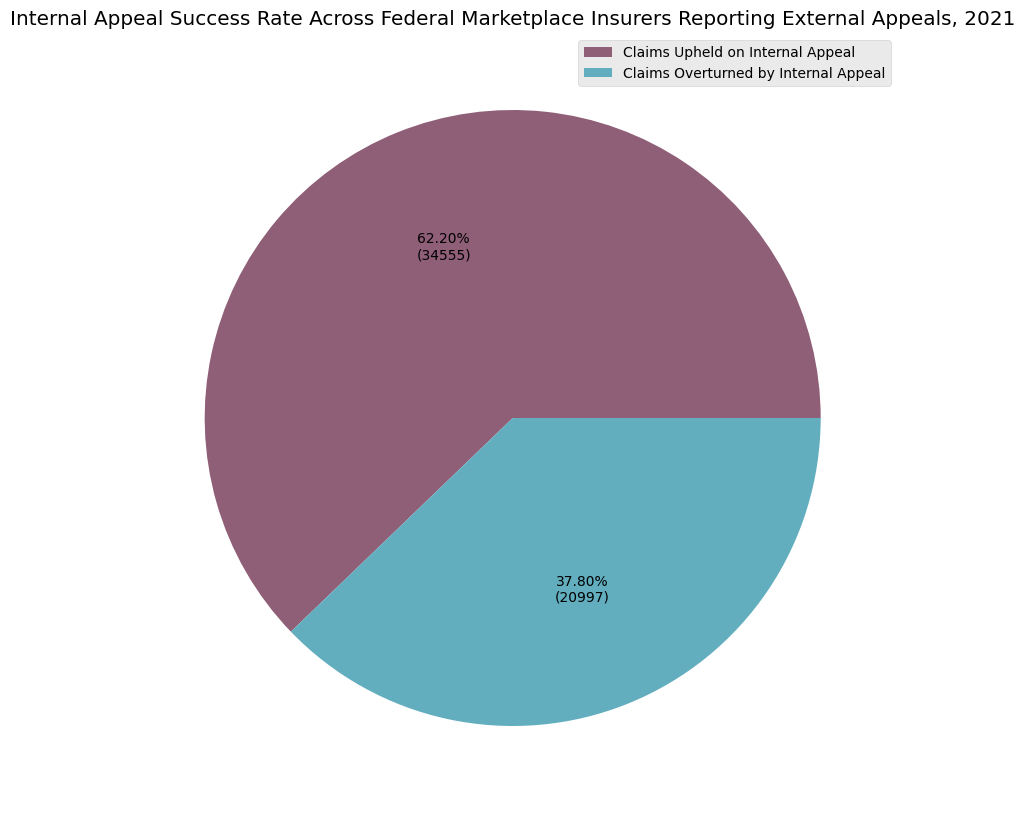

In [94]:
#### Internal Appeal Success Rate
claims_internally_overturned = (
    issuer_external[
        ~issuer_external["Issuer_Number_Internal_Appeals_Overturned"].isnull()
    ]["Issuer_Number_Internal_Appeals_Overturned"]
    .astype(int)
    .sum()
)

claims_internally_appealed = (
    issuer_external[~issuer_external["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)
claims_upheld = claims_internally_appealed - claims_internally_overturned

plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[claims_upheld, claims_internally_overturned],
    title="Internal Appeal Success Rate Across Federal Marketplace Insurers Reporting External Appeals, 2021",
    show=True,
)

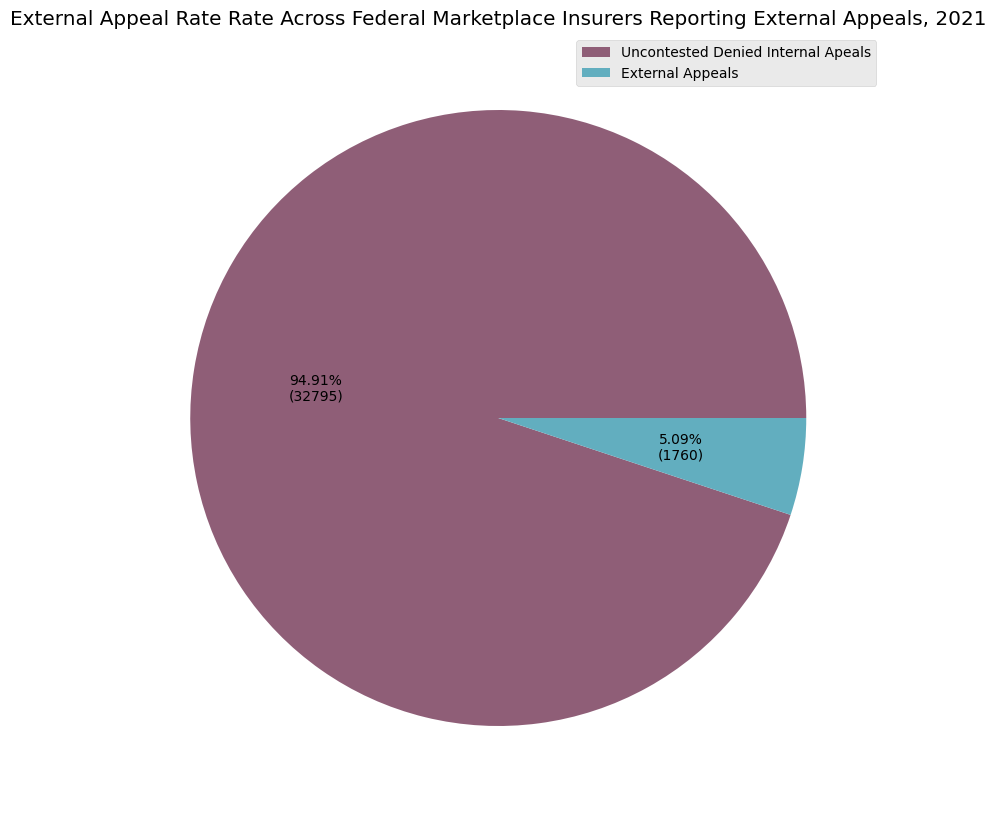

In [96]:
#### External Appeal Rate
claims_externally_appealed = (
    issuer_external[~issuer_external["Issuer_External_Appeals_Filed"].isnull()][
        "Issuer_External_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Uncontested Denied Internal Apeals", "External Appeals"],
    slice_vals=[claims_upheld - claims_externally_appealed, claims_externally_appealed],
    title="External Appeal Rate Rate Across Federal Marketplace Insurers Reporting External Appeals, 2021",
    show=True,
)

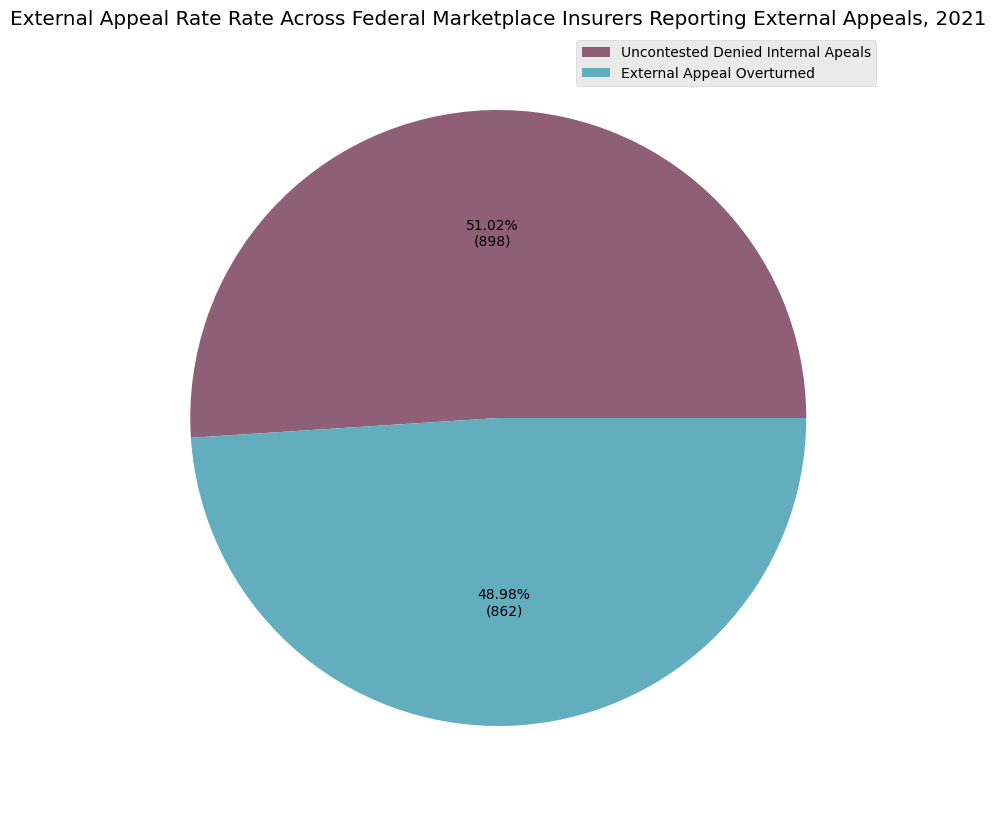

In [98]:
#### External Appeal Success Rate
claims_externally_overturned = (
    issuer_external[
        ~issuer_external["Issuer_Number_External_Appeals_Overturned"].isnull()
    ]["Issuer_Number_External_Appeals_Overturned"]
    .astype(int)
    .sum()
)
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=["Uncontested Denied Internal Apeals", "External Appeal Overturned"],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Rate Rate Across Federal Marketplace Insurers Reporting External Appeals, 2021",
    show=True,
)

In [ ]:
# Federal marketplace states


# TODO: Report the following JS widget over state map:
# hist
# Num issuers represented
# Num enrolees represented
# Num claims represented
# Estimate of value represented


# Q: How do denial rates compare on federal marketplace plans vs state marketplaces? Worst offenders?

In [ ]:
# Motivating Questions Across Data Sources
# ----------------------------------------


# Plot denial rates by state, by year


# Plot denial rates by insurer, by year (how it is progressing?)


# Plot denial type by insurer, by state? What dominates for each insurer, where to focus?

# How often do consumers get denied?

# How often do they appeal?

# How often do they win appeals (internal)?

# How often do they external appeal?

# How often do they win appeals (external)?

# How often do they win, period?

## TODO From this:

1. Create a Deck (Persius MO).
2. Write a detailed report (like KHN) +  arxiv paper.
3. Write a blog post.
4. Publish CT data, other data summaries?